# Pre-processing Data

Address overfitting concerns

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np

In [124]:
DM = pd.read_csv('DMChartEvents.csv',usecols=["hadm_id", "subject_id", "itemid", "charttime","valuenum"])
DM = DM.sort_values(by=['charttime'])
Admissions = pd.read_csv('Admissions.csv',index_col=2)
Patients = pd.read_csv('Patients.csv',index_col=1)

In [125]:
hadm_id = []
subject_id = []
for index,row in DM.iterrows():
    if(row['hadm_id'] not in hadm_id):
        hadm_id.append(row['hadm_id'])
        subject_id.append(row['subject_id'])

In [126]:
d = {'hadm_id': hadm_id, 'subject_id': subject_id}
finalDF = pd.DataFrame(data=d)
finalDF['expire_flag'] = 0

In [127]:
for index,row in finalDF.iterrows():
    expire_flag = Admissions.loc[row['hadm_id'],'HOSPITAL_EXPIRE_FLAG']
    finalDF.at[index,'expire_flag'] = expire_flag

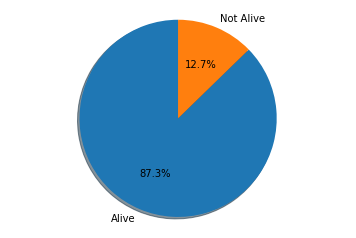

In [128]:
alive = 0
dead = 0
for index,row in finalDF.iterrows():
    if(row['expire_flag'] == 1):
        dead = dead+1
    else:
        alive = alive+1
        
labels = 'Alive', 'Not Alive'
sizes = [alive,dead]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [129]:
finalDF['diagnosis'] = ''
for index,row in finalDF.iterrows():
    diagnosis = Admissions.loc[row['hadm_id'],'DIAGNOSIS']
    finalDF.at[index,'diagnosis'] = diagnosis

In [130]:
finalDF['admission_type'] = ''
for index,row in finalDF.iterrows():
    admission_type = Admissions.loc[row['hadm_id'],'ADMISSION_TYPE']
    finalDF.at[index,'admission_type'] = admission_type

In [131]:
finalDF['age'] = 0
for index,row in finalDF.iterrows():
    birth = Patients.loc[row['subject_id'],'DOB']
    birth = datetime.strptime(birth, '%Y-%m-%d %H:%M:%S')
    birth_year = birth.year
    current = Admissions.loc[row['hadm_id'],'ADMITTIME']
    current = datetime.strptime(current, '%Y-%m-%d %H:%M:%S')
    current_year = current.year
    age = current_year-birth_year
    finalDF.at[index,'age'] = age

In [132]:
glucoseNumbers = {}
for index,row in DM.iterrows():
    glucoseNumbers.setdefault(row['hadm_id'], []).append(row['valuenum'])

In [133]:
finalDF['glucose'] = np.array
for index,row in finalDF.iterrows():
    glucose = glucoseNumbers[row['hadm_id']]
    finalDF.at[index,'glucose'] = glucose

In [137]:
finalDF.to_csv('finalDF.csv', mode='w')

In [138]:
print(finalDF.head(10))

   hadm_id  subject_id  expire_flag                            diagnosis  \
0   101216        8231            0          PERIPJERAL VASCULAR DISEASE   
1   123860         188            0               HEPATIC ENCEPHALOPATHY   
2   194053        9965            0                       ABDOMINAL PAIN   
3   106909         286            0            ASTHMA, COPD EXACERBATION   
4   173194       18902            0                   CAD, RENAL FAILURE   
5   126769         671            0              SUBARACHNOID HEMORRHAGE   
6   117876         357            0                ALTERED MENTAL STATUS   
7   171423        4392            0                           BACTEREMIA   
8   169538         402            0       PULMONARY HYPERTENSION;SYNCOPE   
9   120845         263            0  PERIPHERAL INSUFFICIENCY;RIGHT FOOT   

  admission_type  age                                            glucose  
0      EMERGENCY   78  [71.0, 247.0, 152.0, 160.0, 121.0, 96.0, 63.0,...  
1      EMERGE

In [139]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [140]:
seed = 10
np.random.seed(seed)

In [146]:
finalDFnum = finalDF.values
X = finalDFnum[:,3:6]
Y = finalDFnum[:,2]

In [148]:
def baseline_model():
    model = Sequential()
    model.add(Dense(8, input_dim=3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [149]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

In [150]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [152]:
#results = cross_val_score(estimator, X, Y, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))